# Fraud Email Detection
This project discusses the use of Fraud email detection.

In [1]:
#Importing relevant frameworks and classes
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from transformers import get_cosine_schedule_with_warmup
from textaugment import EDA

In [2]:
#Lets start with configuring environment
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


RANDOM_SEED = 42
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 3e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Importing datasets
df = pd.read_csv('emails.csv')
df = df.drop_duplicates().sample(frac=1).reset_index(drop=True)

In [4]:
#Splitting datasets
if len(np.unique(df['labels'])) == np.bincount(df['labels']).shape[0] == 2:
    stratify_first = df['labels']
else:
    stratify_first = None
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['email_text'], df['labels'],
    test_size = 0.20,
    random_state = RANDOM_SEED,
    stratify = stratify_first #stratification
)
if (len(np.unique(temp_labels)) == 2) and (min(np.bincount(temp_labels)) >= 2):
    stratify_second = temp_labels
else:
    stratify_second = None
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size = 0.5,
    random_state = RANDOM_SEED,
    stratify = stratify_second
)
class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(train_labels),
    y = train_labels
)
class_weights = torch.tensor(class_weights, dtype = torch.float).to(DEVICE)

In [5]:
# collate function
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'label': torch.tensor([item['label'] for item in batch])
    }
#Initializing BERT Tokenizer
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
#Creating Dataloaders
train_dataset = EmailDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = EmailDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = EmailDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [7]:
#Model Initialization
class_counts = torch.bincount(torch.tensor(train_labels, dtype = torch.int64))
class_weights = 1.0 / torch.tensor(class_counts, dtype = torch.float)
class_weights = class_weights.to(DEVICE)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob = 0.2,
    ignore_mismatched_sizes = True
).to(DEVICE)

C:\Users\ihpc\AppData\Local\Temp\ipykernel_3120\855956831.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = 1.0 / torch.tensor(class_counts, dtype = torch.float)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#Optimizers and Schedulers
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.01)
total_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=100,
    num_training_steps=total_steps
)
gradient_accumulation_steps = 2

In [9]:
#Early Stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0

In [10]:
# Training loop with validation
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []  # Track F1 during training
best_val_f1 = 0  # Track best F1 instead of accuracy
patience_counter = 0

criterion = nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0
    optimizer.zero_grad()
    
    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        if (i + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()
            
            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
    print(f'Val Accuracy: {val_accuracy:.4f} | Val F1: {val_f1:.4f}')
    
    # Early Stopping based on F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.bin')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/20
Train Loss: 0.3466 | Val Loss: 0.6895
Val Accuracy: 0.5000 | Val F1: 0.3333
Epoch 2/20
Train Loss: 0.3564 | Val Loss: 0.6895
Val Accuracy: 0.5000 | Val F1: 0.3333
Epoch 3/20
Train Loss: 0.3854 | Val Loss: 0.6895
Val Accuracy: 0.5000 | Val F1: 0.3333
Epoch 4/20
Train Loss: 0.3685 | Val Loss: 0.6895
Val Accuracy: 0.5000 | Val F1: 0.3333
Epoch 5/20
Train Loss: 0.3714 | Val Loss: 0.6895
Val Accuracy: 0.5000 | Val F1: 0.3333
Epoch 6/20
Train Loss: 0.3661 | Val Loss: 0.6895
Val Accuracy: 0.5000 | Val F1: 0.3333
Early stopping triggered


In [11]:
model.load_state_dict(torch.load('best_model.bin'))
model.eval()

test_preds = []
test_labels = []
test_probs = []  # Store probabilities for ROC curve

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        _, preds = torch.max(outputs.logits, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Ensure we have enough test samples
if len(test_labels) < 10:
    print("Warning: Test set is very small. Consider different splitting strategy.")
    
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Results

C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


Accuracy: 0.5000
F1 Score: 0.3333
Precision: 0.2500
Recall: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2


Confusion Matrix:
[[1 0]
 [1 0]]


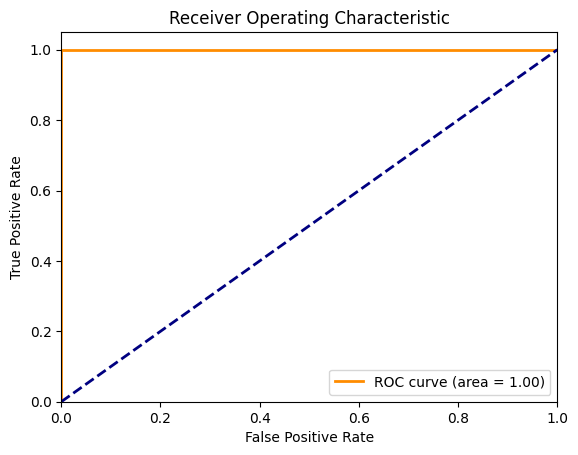

In [12]:
print("\nTest Results")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))
print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

# Plot ROC curve if binary classification
if len(np.unique(test_labels)) == 2:
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(test_labels, [p[1] for p in test_probs])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()